In [ ]:
from google.colab import drive
from google.colab import files

uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
import io
import pandas as pd
import numpy as np

train = pd.read_csv(io.BytesIO(uploaded['train.csv']), dtype=np.float32)

In [ ]:
pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
n_train = len(train)
n_pixels = len(train.columns) - 1
n_class = len(set(train['label']))

print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

Number of training samples: 42000
Number of training pixels: 784
Number of classes: 10


In [ ]:
y_train = train.label.values
x_train = train.loc[:, train.columns != 'label'].values
x_train = x_train/255
x_train = x_train.reshape(-1,28,28,1)

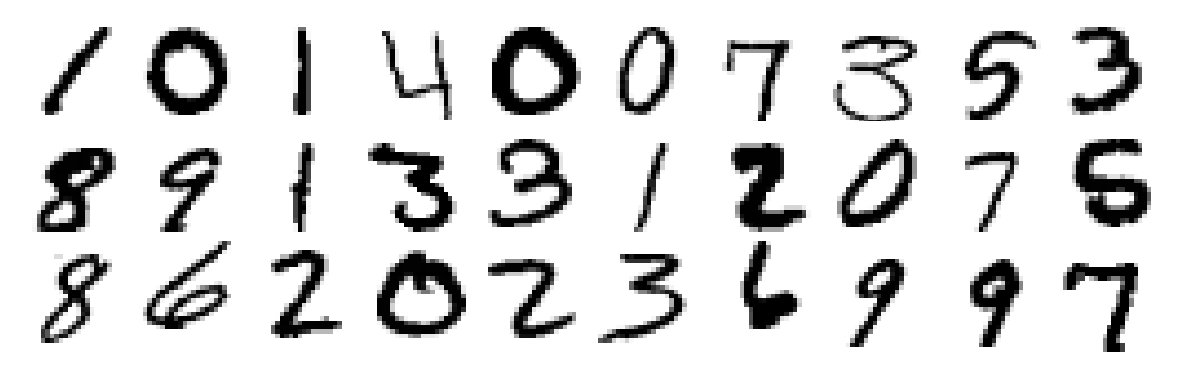

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(x_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [ ]:
x_train = x_train.reshape((-1,1,28,28))
x_train = np.stack((x_train,)*3, axis=1)
x_train = np.squeeze(x_train, axis=2)
x_train.shape

(42000, 3, 28, 28)

In [ ]:
import torch

y_train = torch.from_numpy(y_train).type(torch.LongTensor)

In [ ]:
pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torchvision.models as models
import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')

In [ ]:
Transform = transforms.Compose([transforms.ToTensor()])

BATCH = 64
epochs = 200
LR = 1e-3

In [ ]:
class GetData(Dataset):
    def __init__(self, x_train, y_train, Transform):
        self.X = x_train
        self.transform = Transform
        self.Y = y_train
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.transform(self.X[index]).permute((1, 2, 0)).contiguous(), self.Y[index]

In [ ]:
trainset = GetData(x_train,y_train,Transform)
trainloader = DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=4)

In [ ]:
next(iter(trainloader))[0].shape

torch.Size([32, 3, 28, 28])

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [ ]:
model= nn.Sequential(
    nn.Conv2d(3,32,kernel_size =3, padding =1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 32, kernel_size=5, padding=2, stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.4),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=5, padding=2, stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.4),
    nn.Conv2d(64, 128, kernel_size=4),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Flatten(),
    nn.Dropout(0.4),
    nn.Linear(2048, 10)
    )
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
for epoch in range(epochs):
    tr_loss = 0.0
    correct = 0
    total = 0
    model = model.train()

    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tr_loss += loss.detach().item()
        _,predicted = torch.max(outputs.data,1)
        total+=labels.size(0)
        correct += (predicted ==labels).sum().item()
        
    train_acc = 100 * correct/total

    val_loss = 0.0
    correct = 0
    total = 0
    model = model.eval()
    _, predicted = torch.max(outputs.data, 1)
    total+=labels.size(0)
    correct += (predicted ==labels).sum().item()
    val_acc = 100 * correct / total
    print('Epoch: %d | Loss: %.4f |Train accuracy=:%.5f, Validation accuracy=:%.5f' 
          %(epoch, tr_loss / i ,train_acc,val_acc))

Epoch: 0 | Loss: 0.1614 |Train accuracy=:94.96905, Validation accuracy=:100.00000
Epoch: 1 | Loss: 0.0827 |Train accuracy=:97.64048, Validation accuracy=:93.75000
Epoch: 2 | Loss: 0.0683 |Train accuracy=:98.05714, Validation accuracy=:100.00000
Epoch: 3 | Loss: 0.0568 |Train accuracy=:98.38810, Validation accuracy=:100.00000
Epoch: 4 | Loss: 0.0494 |Train accuracy=:98.58571, Validation accuracy=:93.75000
Epoch: 5 | Loss: 0.0399 |Train accuracy=:98.82143, Validation accuracy=:93.75000
Epoch: 6 | Loss: 0.0374 |Train accuracy=:98.96429, Validation accuracy=:100.00000
Epoch: 7 | Loss: 0.0325 |Train accuracy=:99.03095, Validation accuracy=:100.00000
Epoch: 8 | Loss: 0.0292 |Train accuracy=:99.13095, Validation accuracy=:100.00000
Epoch: 9 | Loss: 0.0218 |Train accuracy=:99.30476, Validation accuracy=:87.50000
Epoch: 10 | Loss: 0.0251 |Train accuracy=:99.20476, Validation accuracy=:93.75000
Epoch: 11 | Loss: 0.0233 |Train accuracy=:99.27381, Validation accuracy=:100.00000
Epoch: 12 | Loss: 0

In [ ]:
torch.save(model.state_dict(), "trained_model_CNN.pt")

In [ ]:
import os

cwd = os.getcwd()
files = os.listdir(cwd)
for file in files:
    if file.endswith(".pt"):
        print("Saved model found:", file)

Saved model found: trained_model_CNN.pt


In [ ]:
cwd

'/content'

In [ ]:
files

['.config', 'trained_model_CNN.pt', 'train.csv', 'sample_data']

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
torch.__version__

'2.0.0+cu118'

In [ ]:
pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 3.9 MB/s eta 0:00:00


In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=5, padding=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.4),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=5, padding=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.4),
            nn.Conv2d(64, 128, kernel_size=4),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Dropout(0.4)
        )

    def forward(self, x):
        features = self.cnn_model(x)
        x = features.view(features.size(0), -1)
        return x

from hmmlearn import hmm

num_states = 10 # Number of states in HMM
num_features = 128 # Number of features extracted from CNN model

In [ ]:
cnn_model = MyCNN()
cnn_model.load_state_dict(torch.load("/content/trained_model_CNN.pt"))

torch.save(cnn_model, "/content/trained_model_CNN_Upt.pt")
cnn_model = torch.load("/content/trained_model_CNN_Upt.pt")

In [ ]:
model.load_state_dict(torch.load("/content/trained_model_CNN.pt"))

torch.save(model, "/content/trained_model_CNN_Upt.pt")
cnn_model = torch.load("/content/trained_model_CNN_Upt.pt")

In [ ]:
for param in cnn_model.parameters():
    param.requires_grad = False

hmm_model = hmm.GaussianHMM(n_components=num_states)
for i, (images, labels) in enumerate(trainloader):
    images = images.to(DEVICE)
    features = cnn_model(images).detach().numpy()
    features = features.reshape(-1, num_states)
    hmm_model.fit(features)

Streaming output truncated to the last 5000 lines.


In [ ]:
class JointModel(nn.Module):
    def __init__(self, cnn_model, HMM_model):
        super(JointModel, self).__init__()
        self.cnn_model = cnn_model
        self.HMM_model = hmm_model

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        x = x.view(-1, channels, height, width)  # Reshape to batch of single images

        features = self.cnn_model(x)
        features = features.view(batch_size, -1)  # Reshape to sequence of feature vectors

        transmat = torch.ones((self.HMM_model.n_components, self.HMM_model.n_components)) / self.HMM_model.n_components
        self.HMM_model.transmat_ = nn.Parameter(transmat, requires_grad=True)

        log_probs = []
        for i in range(batch_size):
            sample = features[i]  # Extract feature sequence for this sample
            sample = sample.reshape(-1, 1)
            _, sample_log_probs = self.HMM_model.score_samples(sample.detach().numpy())  # Calculate log probabilities
            log_probs.append(sample_log_probs)

        log_probs = np.concatenate(log_probs)  # Concatenate log probabilities for all samples
        log_probs = torch.from_numpy(log_probs).to(x.device)  # Convert NumPy array to torch tensor of type float
        probs = torch.exp(log_probs)
        probs = probs.view(batch_size, -1)
        return probs

In [ ]:
# Create the joint model with the pre-trained HMM model
joint_model = JointModel(cnn_model, hmm_model)

# Train the joint model
criterion = nn.NLLLoss()
optimizer = optim.Adam(joint_model.parameters(), lr = 0.1)

num_epochs = 100

for epoch in range(epochs):
    tr_loss = 0.0
    correct = 0
    total = 0
    joint_model = joint_model.train()

    for i, (images, labels) in enumerate(trainloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        labels = labels.view(-1)

        # Forward pass
        probs = joint_model(images)
        log_probs = torch.log(probs)
        log_probs.requires_grad_()
        loss = criterion(log_probs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss += loss.item() * images.size(0)
        _, predicted = torch.max(probs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print('Epoch: %d | Loss: %.4f | Train accuracy: %.5f'
          % (epoch, tr_loss / len(trainloader), train_acc))
    
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    model = model.eval()

    for images, labels in valloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            # Forward pass
            probs = model(images)
            loss = criterion(probs, labels)
            
            val_loss += loss.detach().item()
            _, predicted = torch.max(probs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(valloader) # average validation loss over batches
    val_acc = 100 * val_correct / val_total
    
    print('Epoch: %d | Loss: %.4f | Train accuracy: %.5f | Validation loss: %.4f | Validation accuracy: %.5f' 
          %(epoch, tr_loss / len(trainloader), train_acc, val_loss, val_acc))

Epoch: 0 | Loss: -3.1508 | Train accuracy: 9.85000
Epoch: 1 | Loss: -3.1508 | Train accuracy: 9.85000
Epoch: 2 | Loss: -3.1508 | Train accuracy: 9.85000
Epoch: 3 | Loss: -3.1508 | Train accuracy: 9.85000
Epoch: 4 | Loss: -3.1508 | Train accuracy: 9.85000
Epoch: 5 | Loss: -3.1508 | Train accuracy: 9.85000
Epoch: 6 | Loss: -3.1508 | Train accuracy: 9.85000
Epoch: 7 | Loss: -3.1508 | Train accuracy: 9.85000
Epoch: 8 | Loss: -3.1508 | Train accuracy: 9.85000


KeyboardInterrupt: ignored

In [ ]:
generated_features = HMM_model.sample(5)  # Sample 5 sequences of length 10

# Generate images from the sampled feature sequences
generated_images = cnn_model.decode(torch.from_numpy(generated_features).float())

In [ ]:
generated_features = HMM_model.sample(5)  # Sample 5 sequences of length 10

# Convert the generated features to a tensor and feed them to the decoder of the VAE model
generated_features_tensor = torch.from_numpy(generated_features).float().to(device)
with torch.no_grad():
    generated_images = vae_model.decode(generated_features_tensor)

# Convert the generated images to numpy arrays and reshape them to (batch_size, num_channels, height, width)
generated_images = generated_images.cpu().numpy().reshape(-1, num_channels, height, width)

# Display the generated images
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(generated_images[i].transpose(1, 2, 0))
    axs[i].axis('off')
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, ToTensor

# Load pre-trained Inception-v3 model
inception = inception_v3(pretrained=True, transform_input=False).cuda()
inception.eval()

# Load CIFAR-10 dataset
transform = Compose([Resize((299, 299)), ToTensor()])
dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

# Generate images with GAN and classify with Inception-v3
generated_images = generate_images_with_gan()
predictions = []
with torch.no_grad():
    for batch in dataloader:
        batch = batch.cuda()
        pred = inception(batch)[0].softmax(1)
        predictions.append(pred)
predictions = torch.cat(predictions, dim=0)

# Calculate conditional and marginal class probability distributions
conditional_distributions = []
for i in range(10):
    mask = dataset.targets == i
    probs = predictions[mask].mean(dim=0)
    conditional_distributions.append(probs)
conditional_distributions = torch.stack(conditional_distributions, dim=0)
marginal_distribution = conditional_distributions.mean(dim=0)

# Calculate KL-divergence and Inception score
kl_divergences = []
for probs in conditional_distributions:
    kl_divergence = F.kl_div(probs.log(), marginal_distribution, reduction='batchmean').item()
    kl_divergences.append(kl_divergence)
inception_score = torch.exp(torch.tensor(kl_divergences).mean()).item()

print(f'Inception score: {inception_score:.3f}')